### Mutiara Khairunnisa - 4222201032 - Robotika Pagi 6A

### 1) Dataset Preparation

##### *Use 2600 sample only*

In [10]:
!pip install pandas numpy scikit-learn seaborn

In [11]:
!pip install opencv-python

In [12]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.utils import shuffle

# Visualisasi Image
import cv2

##### *Load Dataset*

In [13]:
# Load Dataset EMNIST letter
df = pd.read_csv("emnist-letters-train.csv", header=None)

# Label terdapat pada kolom pertama
labels = df.iloc[:, 0]
images = df.iloc[:, 1:]

##### *Balanced Class*

In [14]:
# Total class = 26 (EMNIST Letters: label 1 sampai 26, huruf A-Z)
balanced_df = pd.DataFrame()

##### *Each Class has 100 Samples*

In [15]:
for class_label in range(1, 27):  # EMNIST letters: 1–26
    class_samples = df[df[0] == class_label].sample(n=100, random_state=42)
    balanced_df = pd.concat([balanced_df, class_samples])

##### *Shuffle Datasets before Processing*

In [16]:
# Shuffle dataset (acak posisi)
balanced_df = shuffle(balanced_df, random_state=42).reset_index(drop=True)

In [17]:
# Pisahkan label dan data citra
labels_bal = balanced_df.iloc[:, 0]
images_bal = balanced_df.iloc[:, 1:]

##### *Process dataset (binary or CSV) and visualize the image*

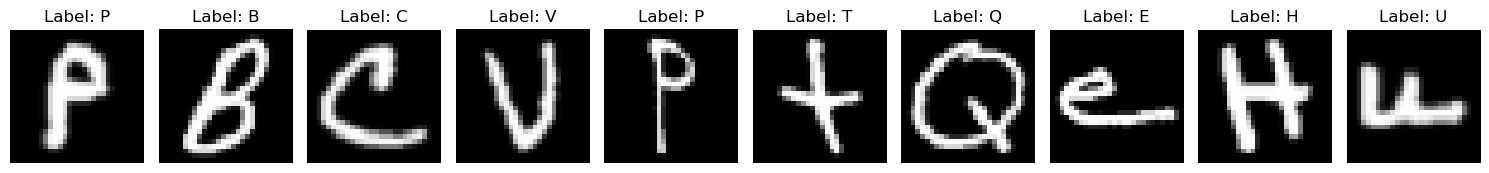

In [18]:
def show_samples(images, labels, n=10):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        img = images.iloc[i].values.reshape(28, 28).T  # Transpose perlu untuk orientasi benar
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {chr(labels.iloc[i] + 64)}")  # Convert 1->A, 2->B, ...
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# tampilkan 10 sampel pertama dari dataset hasil shuffle
show_samples(images_bal, labels_bal)

##### *Split Dataset (80% Training, 20& Testing)*

In [19]:
# Import Library Train and Test Split
from sklearn.model_selection import train_test_split

In [20]:
# Pisahkan fitur (X) dan label (y)
images_bal = balanced_df.iloc[:, 1:]  # Semua kolom kecuali kolom pertama (pixel values)
labels_bal = balanced_df.iloc[:, 0]   # Kolom pertama (label huruf 1–26)

In [21]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    images_bal, labels_bal,
    test_size=0.2,
    stratify=labels_bal,
    random_state=42)

print("Amount of Training Data:", len(X_train))
print("Amount of Testing Data :", len(X_test))

Amount of Training Data: 2080
Amount of Testing Data : 520


In [22]:
print("Labels Distribution of Training Data:")
print(y_train.value_counts().sort_index())

print("Labels Distribution of Testing Data:")
print(y_test.value_counts().sort_index())


Labels Distribution of Training Data:
0
1     80
2     80
3     80
4     80
5     80
6     80
7     80
8     80
9     80
10    80
11    80
12    80
13    80
14    80
15    80
16    80
17    80
18    80
19    80
20    80
21    80
22    80
23    80
24    80
25    80
26    80
Name: count, dtype: int64
Labels Distribution of Testing Data:
0
1     20
2     20
3     20
4     20
5     20
6     20
7     20
8     20
9     20
10    20
11    20
12    20
13    20
14    20
15    20
16    20
17    20
18    20
19    20
20    20
21    20
22    20
23    20
24    20
25    20
26    20
Name: count, dtype: int64


### 2) Feature Extraction

##### *Use HOG Feature Extraction*

In [23]:
# Import Additional Library
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm

In [24]:
# HOG Feature Extract of Train and Test Data
def extract_hog_features(images):
    hog_features = []
    for img in images.values:
        img_reshaped = img.reshape(28, 28).T  # Transpose agar orientasi benar
        features = hog(img_reshaped, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

# Ekstrak HOG dari X_train
X_train_hog = extract_hog_features(X_train)

In [25]:
# Ekstraksi HOG untuk data test
X_test_hog = extract_hog_features(X_test)

# Melatih SVM dengan default parameter
clf = svm.SVC(kernel='linear', C=1)
clf.fit(X_train_hog, y_train)

# Prediksi dan evaluasi di test set
y_pred_test = clf.predict(X_test_hog)

acc_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", acc_test)


Test Accuracy: 0.7423076923076923


##### *Tunning Parameter (Grid Search)*

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

grid = GridSearchCV(svm.SVC(), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train_hog, y_train)

print("Best parameters:", grid.best_params_)

Best parameters: {'C': 10, 'kernel': 'rbf'}


##### *Leave One Out Cross Validation (LOOCV)*

In [27]:
loo = LeaveOneOut()

y_true = []
y_pred = []

clf = svm.SVC(kernel='linear', C=1)

print("LOOCV sedang dijalankan, mohon tunggu...")

# Proses LOOCV (akan lambat, gunakan tqdm untuk progres bar)
for train_index, test_index in tqdm(loo.split(X_train_hog), total=len(X_train_hog)):
    X_tr, X_val = X_train_hog[train_index], X_train_hog[test_index]
    y_tr, y_val = y_train.values[train_index], y_train.values[test_index]

    clf.fit(X_tr, y_tr)
    pred = clf.predict(X_val)

    y_true.extend(y_val)
    y_pred.extend(pred)

LOOCV sedang dijalankan, mohon tunggu...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2080/2080 [07:17<00:00,  4.75it/s]



=== Evaluasi LOOCV pada Data Training ===
Accuracy : 0.7764423076923077
Precision: 0.7803910168538787
F1-score : 0.7774798085761978


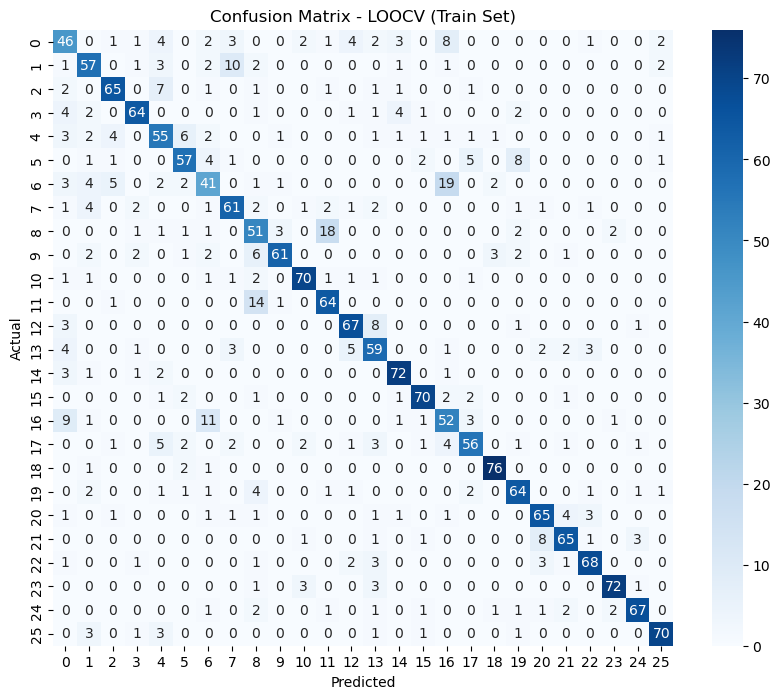

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print("\n=== Evaluasi LOOCV pada Data Training ===")
print("Accuracy :", acc)
print("Precision:", precision)
print("F1-score :", f1)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", annot=True, fmt="d")
plt.title("Confusion Matrix - LOOCV (Train Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

##### *Change the default parameters (orientation, pixels_per_cell, cells_per_block)*

In [29]:
from skimage.feature import hog
from tqdm import tqdm

# Parameter HOG custom
orientations = 12
pixels_per_cell = (4, 4)
cells_per_block = (2, 2)
block_norm = 'L1'

In [30]:
import numpy as np
from skimage.feature import hog

hog_features = []

for i in range(len(images_bal)):
    img = images_bal.iloc[i].values.reshape(28, 28)  # ambil satu gambar, ubah ke array, reshape 28x28
    img = np.flip(img.T, axis=0)  # koreksi orientasi jika perlu (EMNIST)
    
    features = hog(img, pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=9)
    hog_features.append(features)

print(images_bal.shape)
print(images_bal.iloc[0].values.shape)


(2600, 784)
(784,)


### 3) Classification

##### *Use Support Vector Machine (SVM) for classification and Change default SVM Parameters (Kernel type, Regularization (C), Gamma)*

In [31]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Training SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # hanya relevan untuk kernel 'rbf'
}

##### *Use Grid Search Techniques to find the best performance*

In [32]:
print("Sedang menjalankan Grid Search SVM (cv=5)...")
grid = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train_hog, y_train)

Sedang menjalankan Grid Search SVM (cv=5)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             verbose=1)

In [33]:
# Simpan model terbaik dari Grid Search
best_svm = grid.best_estimator_
print("\nBest Parameters:", grid.best_params_)


Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


##### *Measure Training Performance using LOOCV*

In [34]:
loo = LeaveOneOut()
y_true_loo = []
y_pred_loo = []

print("\nEvaluasi LOOCV sedang berjalan, mohon tunggu...")

for train_index, test_index in tqdm(loo.split(X_train_hog), total=len(X_train_hog)):
    X_tr, X_val = X_train_hog[train_index], X_train_hog[test_index]
    y_tr, y_val = y_train.values[train_index], y_train.values[test_index]

    best_svm.fit(X_tr, y_tr)
    pred = best_svm.predict(X_val)

    y_true_loo.append(y_val[0])
    y_pred_loo.append(pred[0])



Evaluasi LOOCV sedang berjalan, mohon tunggu...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2080/2080 [13:39<00:00,  2.54it/s]



=== Evaluasi Performa Training dengan LOOCV ===
Accuracy : 0.8168269230769231
Precision: 0.8192016524139513
F1-score : 0.817270855088261


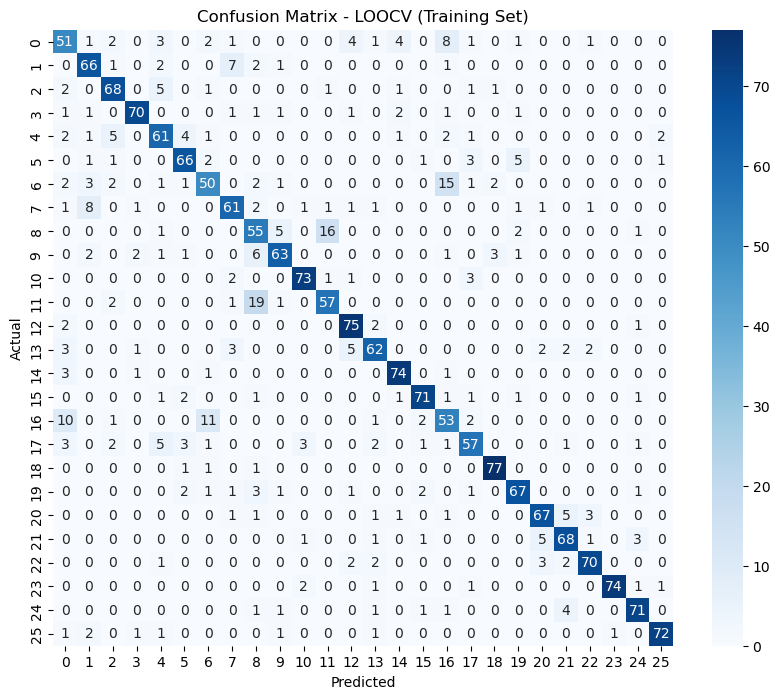

In [35]:
# Hitung metrik evaluasi
cm = confusion_matrix(y_true_loo, y_pred_loo)
acc = accuracy_score(y_true_loo, y_pred_loo)
precision = precision_score(y_true_loo, y_pred_loo, average='macro', zero_division=0)
f1 = f1_score(y_true_loo, y_pred_loo, average='macro', zero_division=0)

print("\n=== Evaluasi Performa Training dengan LOOCV ===")
print("Accuracy :", acc)
print("Precision:", precision)
print("F1-score :", f1)

# Tampilkan Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", annot=True, fmt="d")
plt.title("Confusion Matrix - LOOCV (Training Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 4) Evaluation

##### *Evaluate on train (80%) & test datasets (20%) and Performance Metrics (Accuracy, Precision, Recall, F1_score)*


=== EVALUASI MODEL PADA TRAINING SET (80%) ===
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        80
           2     1.0000    1.0000    1.0000        80
           3     1.0000    1.0000    1.0000        80
           4     1.0000    1.0000    1.0000        80
           5     1.0000    1.0000    1.0000        80
           6     1.0000    1.0000    1.0000        80
           7     1.0000    1.0000    1.0000        80
           8     1.0000    1.0000    1.0000        80
           9     0.9872    0.9625    0.9747        80
          10     1.0000    1.0000    1.0000        80
          11     1.0000    1.0000    1.0000        80
          12     0.9634    0.9875    0.9753        80
          13     1.0000    1.0000    1.0000        80
          14     1.0000    1.0000    1.0000        80
          15     1.0000    1.0000    1.0000        80
          16     1.0000    1.0000    1.0000        80
          17     1.0000    1.0000

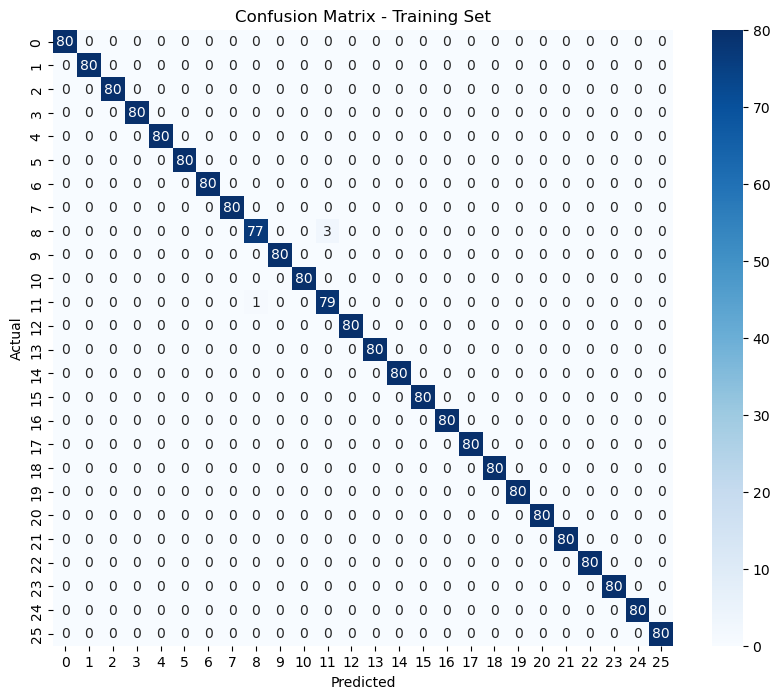

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluasi Training Set
y_pred_train = best_svm.predict(X_train_hog)

print("\n=== EVALUASI MODEL PADA TRAINING SET (80%) ===")
print(classification_report(y_train, y_pred_train, digits=4, zero_division=0))

# Confusion Matrix Train
cm_train = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, cmap="Blues", annot=True, fmt="d")
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


=== EVALUASI MODEL PADA TEST SET (20%) ===
              precision    recall  f1-score   support

           1     0.4783    0.5500    0.5116        20
           2     0.7333    0.5500    0.6286        20
           3     0.7647    0.6500    0.7027        20
           4     0.8421    0.8000    0.8205        20
           5     0.6400    0.8000    0.7111        20
           6     0.9412    0.8000    0.8649        20
           7     0.5500    0.5500    0.5500        20
           8     0.6818    0.7500    0.7143        20
           9     0.5000    0.6500    0.5652        20
          10     0.7647    0.6500    0.7027        20
          11     0.9500    0.9500    0.9500        20
          12     0.6875    0.5500    0.6111        20
          13     0.8125    0.6500    0.7222        20
          14     0.6800    0.8500    0.7556        20
          15     0.8333    1.0000    0.9091        20
          16     0.8000    0.8000    0.8000        20
          17     0.5000    0.5000    

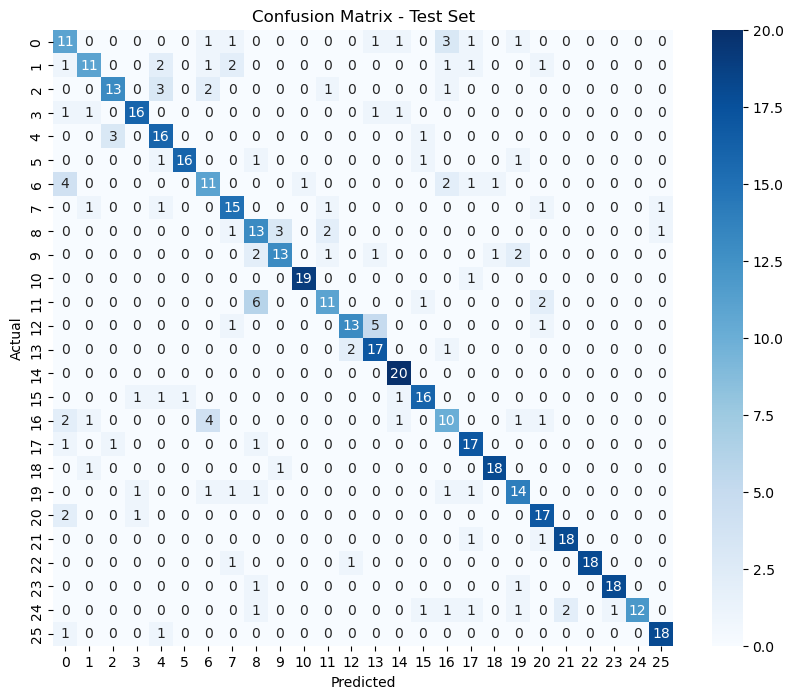

In [37]:
# Evaluasi Test set
y_pred_test = best_svm.predict(X_test_hog)

print("\n=== EVALUASI MODEL PADA TEST SET (20%) ===")
print(classification_report(y_test, y_pred_test, digits=4, zero_division=0))

# Confusion Matrix Test
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, cmap="Blues", annot=True, fmt="d")
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()